# Set Inital Env

In [1]:
# check current working directory
print(getwd())

# reset to the root directory
setwd("..")
print(getwd())

[1] "C:/Users/y/github/dtw/code/demo_HousingMarket"
[1] "C:/Users/y/github/dtw/code"


In [2]:
sessionInfo()

R version 4.1.2 (2021-11-01)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 19042)

Matrix products: default

locale:
[1] LC_COLLATE=English_United States.1252 
[2] LC_CTYPE=English_United States.1252   
[3] LC_MONETARY=English_United States.1252
[4] LC_NUMERIC=C                          
[5] LC_TIME=English_United States.1252    

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

loaded via a namespace (and not attached):
 [1] fansi_0.5.0     crayon_1.4.2    digest_0.6.29   utf8_1.2.2     
 [5] IRdisplay_1.1   repr_1.1.4      lifecycle_1.0.1 jsonlite_1.8.5 
 [9] evaluate_0.14   pillar_1.6.4    rlang_1.0.6     cli_3.4.1      
[13] uuid_1.0-3      vctrs_0.3.8     ellipsis_0.3.2  IRkernel_1.3   
[17] tools_4.1.2     fastmap_1.1.0   compiler_4.1.2  base64enc_0.1-3
[21] pbdZMQ_0.3-6    htmltools_0.5.2

In [3]:
rm(list = ls())
library(data.table)
library(magrittr)
library(ggplot2)
library(Rcpp)
library(dtw)

sourceCpp("shapeDTW_translate/dpcore.cpp")
source("dpfast.R")
source("dist2.R")
source("weightFunc.R")
source("shapeDTW_translate/shapeDTW.R")
source("shapeDTW_translate/DTWfast.R")
source("shapeDTW_translate/hist_cost_2.R")
source("shapeDTW_translate/zNormalizeTS.R")
source("shapeDTW_translate/samplingSequencesIdx.R")
source("shapeDTW_translate/calcDescriptor.R")
source("shapeDTW_translate/descriptorPAA.R")
source("shapeDTW_translate/PAA.R")
source("shapeDTW_translate/descriptorHOG1D.R")
source("shapeDTW_translate/validatePAAparam.R")
source("shapeDTW_translate/validatePAAdescriptorparam.R")
source("shapeDTW_translate/validateHOG1Dparam.R")
source("shapeDTW_translate/validateDWTdescriptorparam.R")
source("shapeDTW_translate/whichInterval.R")
source("shapeDTW_translate/wpath2mat.R")
source("shapeDTW_translate/plotElasticMatching.R")

options(repr.plot.width = 18, repr.plot.height = 8)

Warning message:
"package 'dtw' was built under R version 4.1.3"
Loading required package: proxy


Attaching package: 'proxy'


The following objects are masked from 'package:stats':

    as.dist, dist


The following object is masked from 'package:base':

    as.matrix


Loaded dtw v1.23-1. See ?dtw for help, citation("dtw") for use in publication.




# Load Data

In [4]:
dt <- fread('demo_HousingMarket/data_sfh.csv')
str(dt)

Classes 'data.table' and 'data.frame':	104444 obs. of  21 variables:
 $ period_begin                  : IDate, format: "2012-01-01" "2012-02-01" ...
 $ period_end                    : IDate, format: "2012-01-31" "2012-02-29" ...
 $ period_duration               : int  30 30 30 30 30 30 30 30 30 30 ...
 $ region                        : chr  "Aberdeen, SD metro area" "Aberdeen, SD metro area" "Aberdeen, SD metro area" "Aberdeen, SD metro area" ...
 $ state_code                    : chr  "SD" "SD" "SD" "SD" ...
 $ median_sale_price             : num  64000 159300 93000 112500 116900 ...
 $ median_list_price             : num  226250 99900 143200 111900 109900 ...
 $ median_ppsf                   : num  44.6 80.6 67.3 57.2 54.6 ...
 $ median_list_ppsf              : num  66.3 54.8 71.9 61.4 62.9 ...
 $ homes_sold                    : int  3 1 3 3 6 3 6 4 6 9 ...
 $ pending_sales                 : int  1 NA 2 1 3 1 1 4 3 3 ...
 $ new_listings                  : int  2 3 14 2 3 10 4 8 8 2 .

## Drop Metros with Missing Data

In [5]:
# NA's
colSums(is.na(dt))

period_begin                     period_end 
                             0                              0 
               period_duration                         region 
                             0                              0 
                    state_code              median_sale_price 
                             0                            102 
             median_list_price                    median_ppsf 
                          2644                            295 
              median_list_ppsf                     homes_sold 
                          2771                            102 
                 pending_sales                   new_listings 
                          5323                           2973 
                     inventory               months_of_supply 
                          1118                            644 
                    median_dom               avg_sale_to_list 
                          1042                           3754 
               sold_above_list                    price_drops 
                           136                          53764 
       off_market_in_two_weeks            parent_metro_region 
                          4941                              0 
parent_metro_region_metro_code 
                             0

In [6]:
# Select metros without NAs
dt[, ':='(id_NA = max(is.na(median_sale_price)|is.na(median_ppsf)), n_month = .N)
   , by='region']
dt_nonNA <- dt[id_NA==FALSE]

metro_list_all <- unique(dt$region)
metro_list_nonNA <- unique(dt_nonNA$region)
cat(paste0('Number of All Regions: ', length(metro_list_all),
           '\nNumber of Regions w/o NAs: ', length(metro_list_nonNA)))

Number of All Regions: 909
Number of Regions w/o NAs: 856

## Select Metros with Same Data Length

In [7]:
# Check the distribution of data length by metro
table(dt_nonNA[, .(len = unique(n_month)), by='region']$len)


  4   5   6   7  16  18  20  21  22  24  25  26  27  29  30  31  34  36  40  41 
  1   1   1   1   1   1   2   1   1   2   2   2   2   1   2   1   1   1   5   2 
 42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61 
  2   2   3   4   2   4   1   2   5   4   3  11   5   2   4   5   7   5   3   4 
 62  63  64  65  67  68  69  70  71  72  73  74  75  77  78  79  81  83  84  85 
  4   2   1   2   5   1   2   5   4   1   4   5   3   3   1   2   2   2   2   3 
 86  87  89  90  91  92  94  95  96  97  98  99 100 102 103 104 105 106 107 108 
  3   1   1   2   2   1   1   3   7   2   4   4   3  14   4   3   1   3   4   3 
111 112 113 114 115 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 
  3   1   1   2   3   3   1   3   2   2  12   2   2   1   2   2   3   7   4   6 
133 134 135 136 
  9  13  13 530 

In [8]:
# Find metros of interest
metro_interest <- c('Austin', 'Detroit', 'New York', 'Chicago')
for (m in metro_interest) {
    metro <- grep(m, metro_list_nonNA, value=TRUE)
    print(dt_nonNA[region %in% metro
                   , .(start=min(period_begin), end=max(period_begin), n_month=unique(n_month))
                   , by='region'])
}

                  region      start        end n_month
1: Austin, MN metro area 2012-01-01 2023-04-01     136
2: Austin, TX metro area 2012-01-01 2023-04-01     136
                   region      start        end n_month
1: Detroit, MI metro area 2013-02-01 2023-04-01     123
                    region      start        end n_month
1: New York, NY metro area 2015-05-01 2023-04-01      96
                   region      start        end n_month
1: Chicago, IL metro area 2012-01-01 2023-04-01     136


In [9]:
# Select metros with the same length of data (7 years and 4 months upto 2023 April)
dt_sel <- dt_nonNA[period_begin>=as.Date("2016-01-01")][
    , sel := max(sum(period_begin>=as.Date("2016-01-01"))==((2023-2016)*12+4))
    , by='region'][sel==1]
str(dt_sel)

Classes 'data.table' and 'data.frame':	54208 obs. of  24 variables:
 $ period_begin                  : IDate, format: "2016-01-01" "2016-02-01" ...
 $ period_end                    : IDate, format: "2016-01-31" "2016-02-29" ...
 $ period_duration               : int  30 30 30 30 30 30 30 30 30 30 ...
 $ region                        : chr  "Aberdeen, SD metro area" "Aberdeen, SD metro area" "Aberdeen, SD metro area" "Aberdeen, SD metro area" ...
 $ state_code                    : chr  "SD" "SD" "SD" "SD" ...
 $ median_sale_price             : num  157275 153500 145000 139450 145000 ...
 $ median_list_price             : num  153500 151900 158900 179000 141900 ...
 $ median_ppsf                   : num  75 64 73.4 70 67.2 ...
 $ median_list_ppsf              : num  70.5 70.3 76.4 88.8 67.2 ...
 $ homes_sold                    : int  4 6 9 10 16 10 14 10 11 12 ...
 $ pending_sales                 : int  2 3 5 3 5 9 7 5 2 8 ...
 $ new_listings                  : int  7 8 20 11 12 16 10 12

# TD-ShapeDTW

In [10]:
metro_list_sel <- unique(dt_sel$region)
print(length(metro_list_sel))

# target metro
metro_t <- grep('Seattle', metro_list_sel, value=TRUE)
metro_t

[1] 616


[1] "Seattle, WA metro area"

In [11]:
var_sel <- c('median_sale_price', 'median_ppsf')
dt_sel[, (paste0(var_sel, '_std')) := lapply(.SD, zNormalizeTS)
       , .SDcols=var_sel, by='region']
str(dt_sel)

Classes 'data.table' and 'data.frame':	54208 obs. of  26 variables:
 $ period_begin                  : IDate, format: "2016-01-01" "2016-02-01" ...
 $ period_end                    : IDate, format: "2016-01-31" "2016-02-29" ...
 $ period_duration               : int  30 30 30 30 30 30 30 30 30 30 ...
 $ region                        : chr  "Aberdeen, SD metro area" "Aberdeen, SD metro area" "Aberdeen, SD metro area" "Aberdeen, SD metro area" ...
 $ state_code                    : chr  "SD" "SD" "SD" "SD" ...
 $ median_sale_price             : num  157275 153500 145000 139450 145000 ...
 $ median_list_price             : num  153500 151900 158900 179000 141900 ...
 $ median_ppsf                   : num  75 64 73.4 70 67.2 ...
 $ median_list_ppsf              : num  70.5 70.3 76.4 88.8 67.2 ...
 $ homes_sold                    : int  4 6 9 10 16 10 14 10 11 12 ...
 $ pending_sales                 : int  2 3 5 3 5 9 7 5 2 8 ...
 $ new_listings                  : int  7 8 20 11 12 16 10 12

In [12]:
metro_t_dist <- dt_sel[, .(dtw=0, shapedtw=0), by='region']
metro_t_dist_results <- list()

seq_ref <- as.matrix(dt_sel[region==metro_t]$median_sale_price_std, ncol=1)
steppattern <- matrix(c(1, 1, 2.0, 0, 1, 1.0, 1, 0, 1.0), ncol = 3, byrow = TRUE)

tik <- Sys.time()
for (m in metro_list_sel) {
    seq_q <- as.matrix(dt_sel[region==m]$median_sale_price_std, ncol=1)

    # DTW
    dist_DTW <- dist2(x = seq_ref, c = seq_q)
    align_DTW <- dpfast(dist_DTW, C = steppattern)
    # WDTW
    dist_WDTW <- dist2(x = seq_ref, c = seq_q, wt_func = weight_fcn)
    align_WDTW <- dpfast(dist_WDTW, C = steppattern)
    # TD-WDTW
    dist_td_WDTW <- dist2(x = seq_ref, c = seq_q, wt_func = weight_fcn_prod)
    align_td_WDTW <- dpfast(dist_td_WDTW, C = steppattern)
    # ShapeDTW
    align_shapeDTW <- shapeDTW(c(seq_ref), c(seq_q), seqlen=5)
    # TD-ShapeDTW
    align_td_shapeDTW <- shapeDTW(c(seq_ref), c(seq_q), seqlen=5, wt_func = weight_fcn_prod) # <<<--- check wt_func; add time-dimension weights only
    
    metro_t_dist_results[m] <- list(list('align_DTW' = align_DTW,
                                         'align_WDTW' = align_WDTW,
                                         'align_td_WDTW' = align_td_WDTW,
                                         'align_shapeDTW' = align_shapeDTW,
                                         'align_td_shapeDTW' = align_td_shapeDTW))
    
    metro_t_dist[region==m, ':='(dtw = sum(align_DTW$sc),
                                 wdtw = sum(align_WDTW$sc),
                                 td_wdtw = sum(align_td_WDTW$sc),
                                 shapedtw = align_shapeDTW$distDescriptor,
                                 td_shapedtw = align_td_shapeDTW$distDescriptor)]
}
tok <- Sys.time()
print(round(tok-tik, 2))

metrics <- c('dtw', 'wdtw', 'td_wdtw', 'shapedtw', 'td_shapedtw')
metro_t_dist[, (paste0(metrics, '_rank')) := lapply(.SD, function(x) frank(x, ties.method='min'))
             , .SDcols=metrics]

Time difference of 56.86 secs


In [13]:
head(metro_t_dist[order(td_shapedtw_rank)], 20)

region,dtw,shapedtw,wdtw,td_wdtw,td_shapedtw,dtw_rank,wdtw_rank,td_wdtw_rank,shapedtw_rank,td_shapedtw_rank
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>
"Seattle, WA metro area",0.000000,0.0000,0.0000000,0.0000000,0.00000,1,1,1,1,1
"Dallas, TX metro area",11.590782,150.5698,0.1727441,0.9767218,10.88286,12,18,16,4,2
"Denver, CO metro area",10.676021,150.1148,0.1433253,0.8512331,11.45808,6,4,4,3,3
"Atlanta, GA metro area",12.347193,150.0164,0.1746844,0.9678757,11.87480,25,20,14,2,4
"Grand Rapids, MI metro area",12.596061,159.9590,0.1766650,1.0916998,12.43184,34,24,53,6,5
"Minneapolis, MN metro area",11.607907,156.0842,0.1631267,0.9586988,12.46879,14,10,11,5,6
"Spokane, WA metro area",11.464874,161.8362,0.1769252,0.9077368,12.69336,10,26,10,9,7
"Columbus, OH metro area",12.818660,165.8282,0.1760267,1.0757576,12.72322,40,23,46,15,8
"San Diego, CA metro area",11.329300,161.0954,0.1542985,0.8747076,12.74243,9,6,6,7,9


In [14]:
head(metro_t_dist[order(td_wdtw_rank)], 20)

region,dtw,shapedtw,wdtw,td_wdtw,td_shapedtw,dtw_rank,wdtw_rank,td_wdtw_rank,shapedtw_rank,td_shapedtw_rank
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>
"Seattle, WA metro area",0.000000,0.0000,0.0000000,0.0000000,0.00000,1,1,1,1,1
"Anaheim, CA metro area",10.380452,176.9442,0.1640568,0.8203982,14.20796,3,11,2,26,28
"Portland, OR metro area",10.443825,172.3792,0.1387020,0.8498496,13.55075,4,3,3,22,17
"Denver, CO metro area",10.676021,150.1148,0.1433253,0.8512331,11.45808,6,4,4,3,3
"Sacramento, CA metro area",9.992439,164.1219,0.1340301,0.8549252,13.12133,2,2,5,11,11
"San Diego, CA metro area",11.329300,161.0954,0.1542985,0.8747076,12.74243,9,6,6,7,9
"Salt Lake City, UT metro area",11.163460,165.8151,0.1574753,0.8877065,13.50013,8,8,7,14,16
"Fort Worth, TX metro area",10.563748,177.8909,0.1528086,0.9002695,14.65643,5,5,8,28,36
"Modesto, CA metro area",10.818532,185.5212,0.1557644,0.9022104,15.03690,7,7,9,40,43


## Matching Plot (to-be-updated)

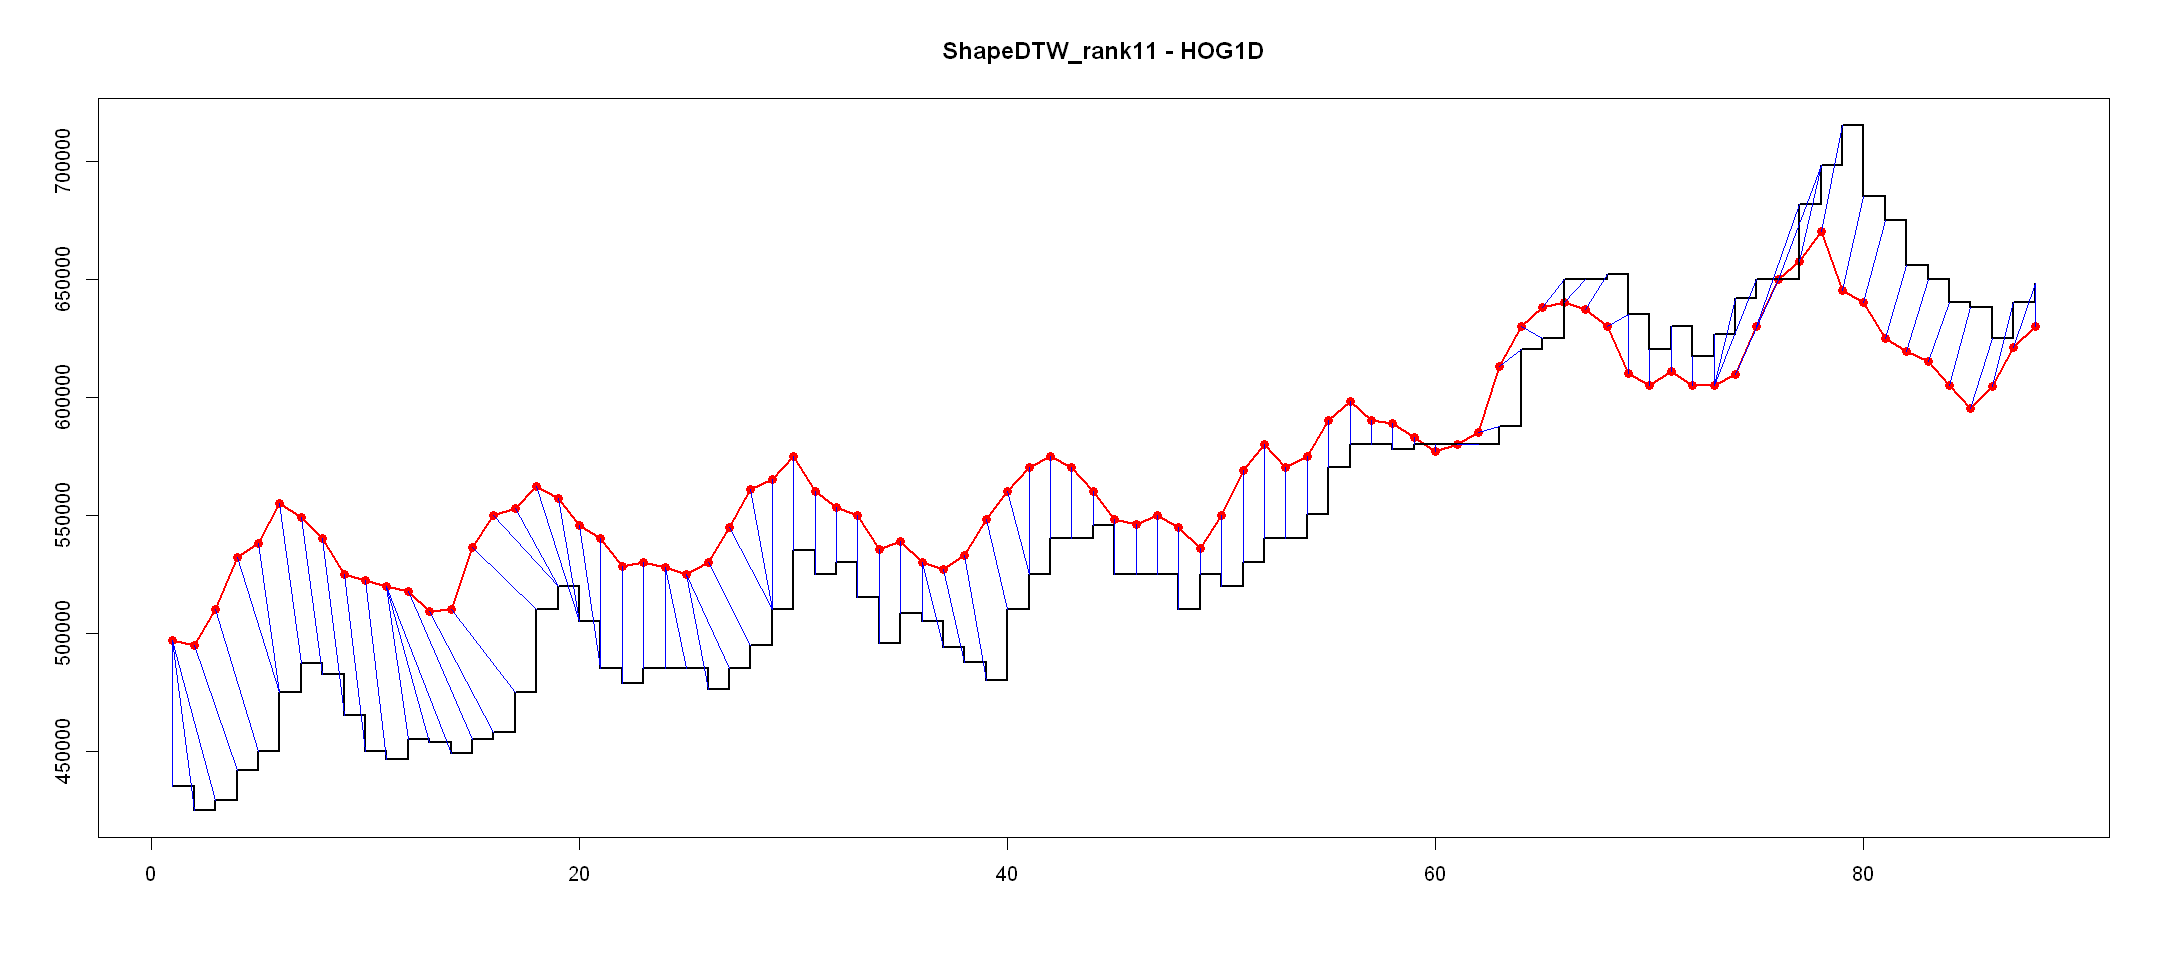

In [15]:
metro_t <- 'Chicago, IL metro area'
metro_q <- 'New York, NY metro area'
plotElasticMatching(dt_sel[region==metro_t]$median_sale_price, 
                    dt_sel[region==metro_q]$median_sale_price, 
                    metro_t_dist_results[[metro_q]]$align_td_shapeDTW$match)
title("ShapeDTW_rank11 - HOG1D")

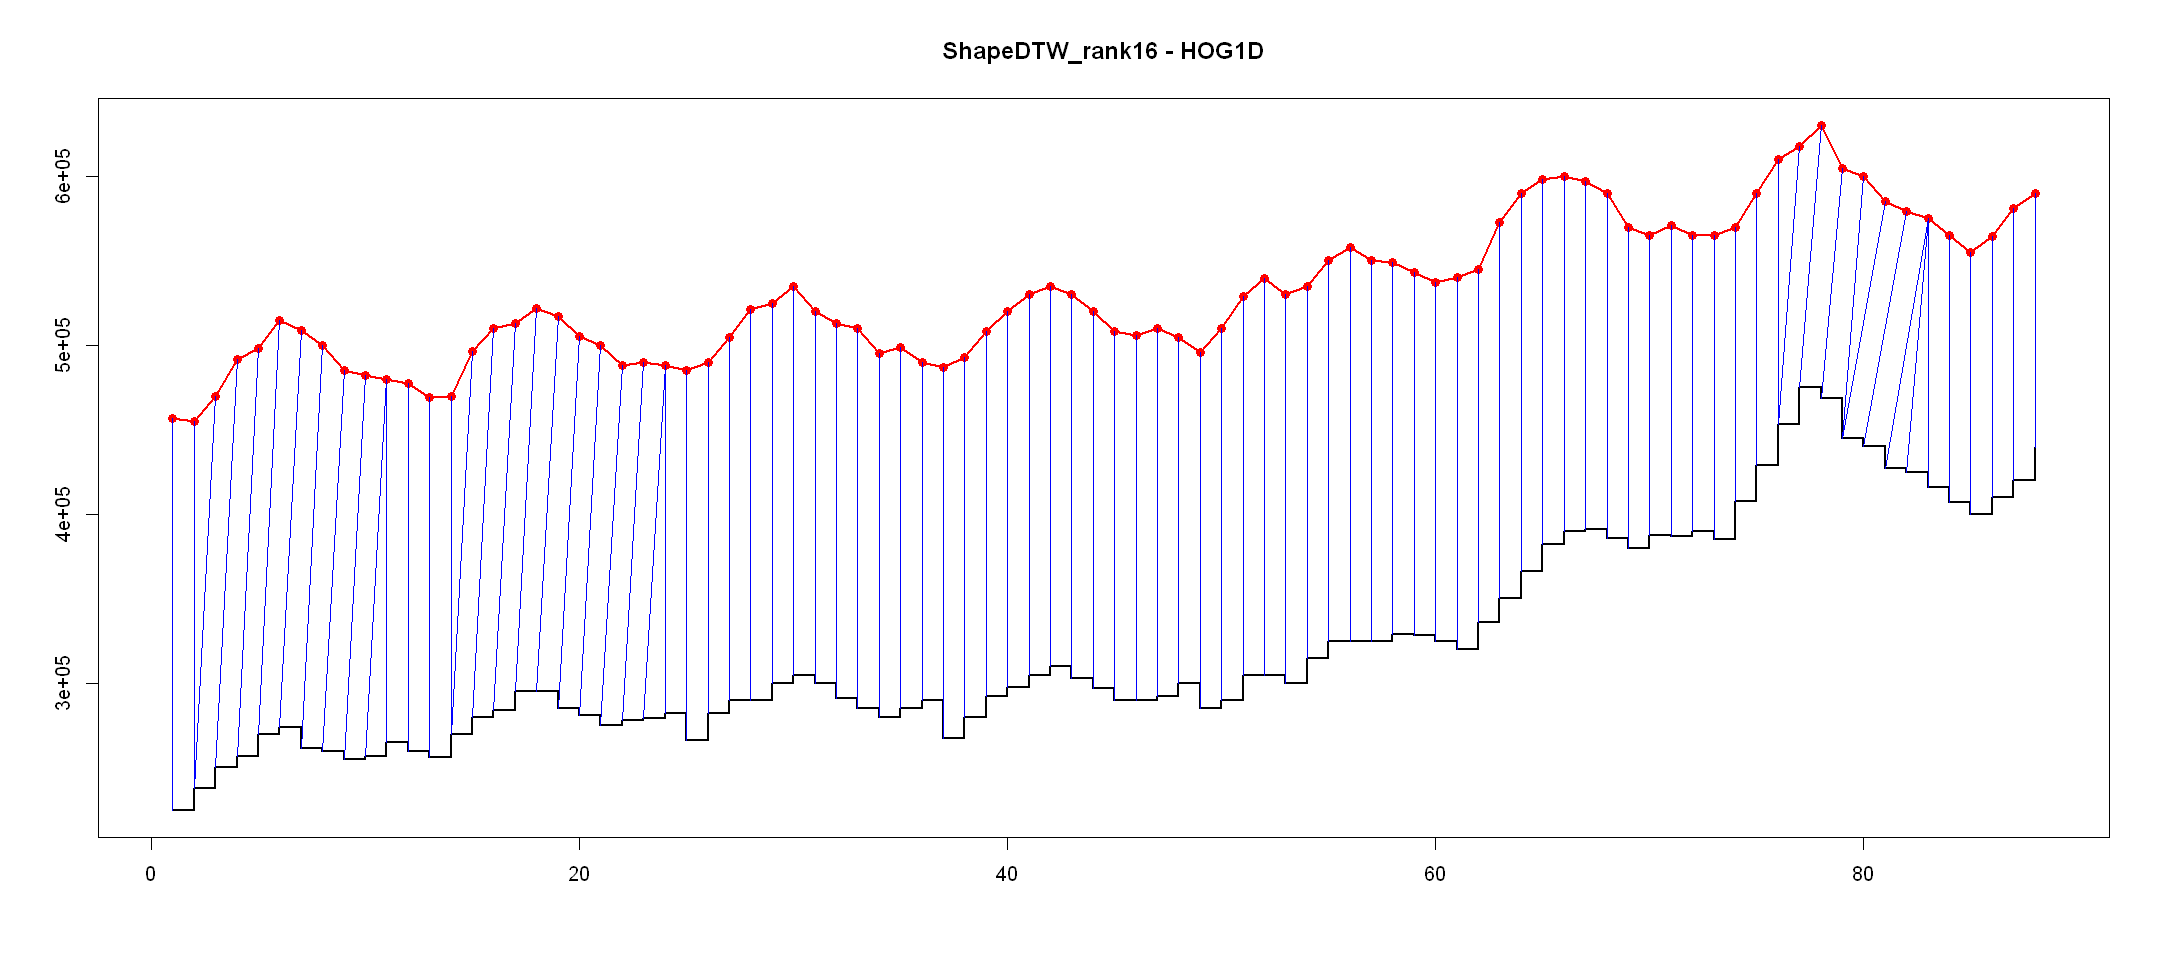

In [16]:
metro_q <- 'Dallas, TX metro area'
plotElasticMatching(dt_sel[region==metro_t]$median_sale_price, 
                    dt_sel[region==metro_q]$median_sale_price, 
                    metro_t_dist_results[[metro_q]]$align_td_shapeDTW$match)
title("ShapeDTW_rank16 - HOG1D")

## Data Plot

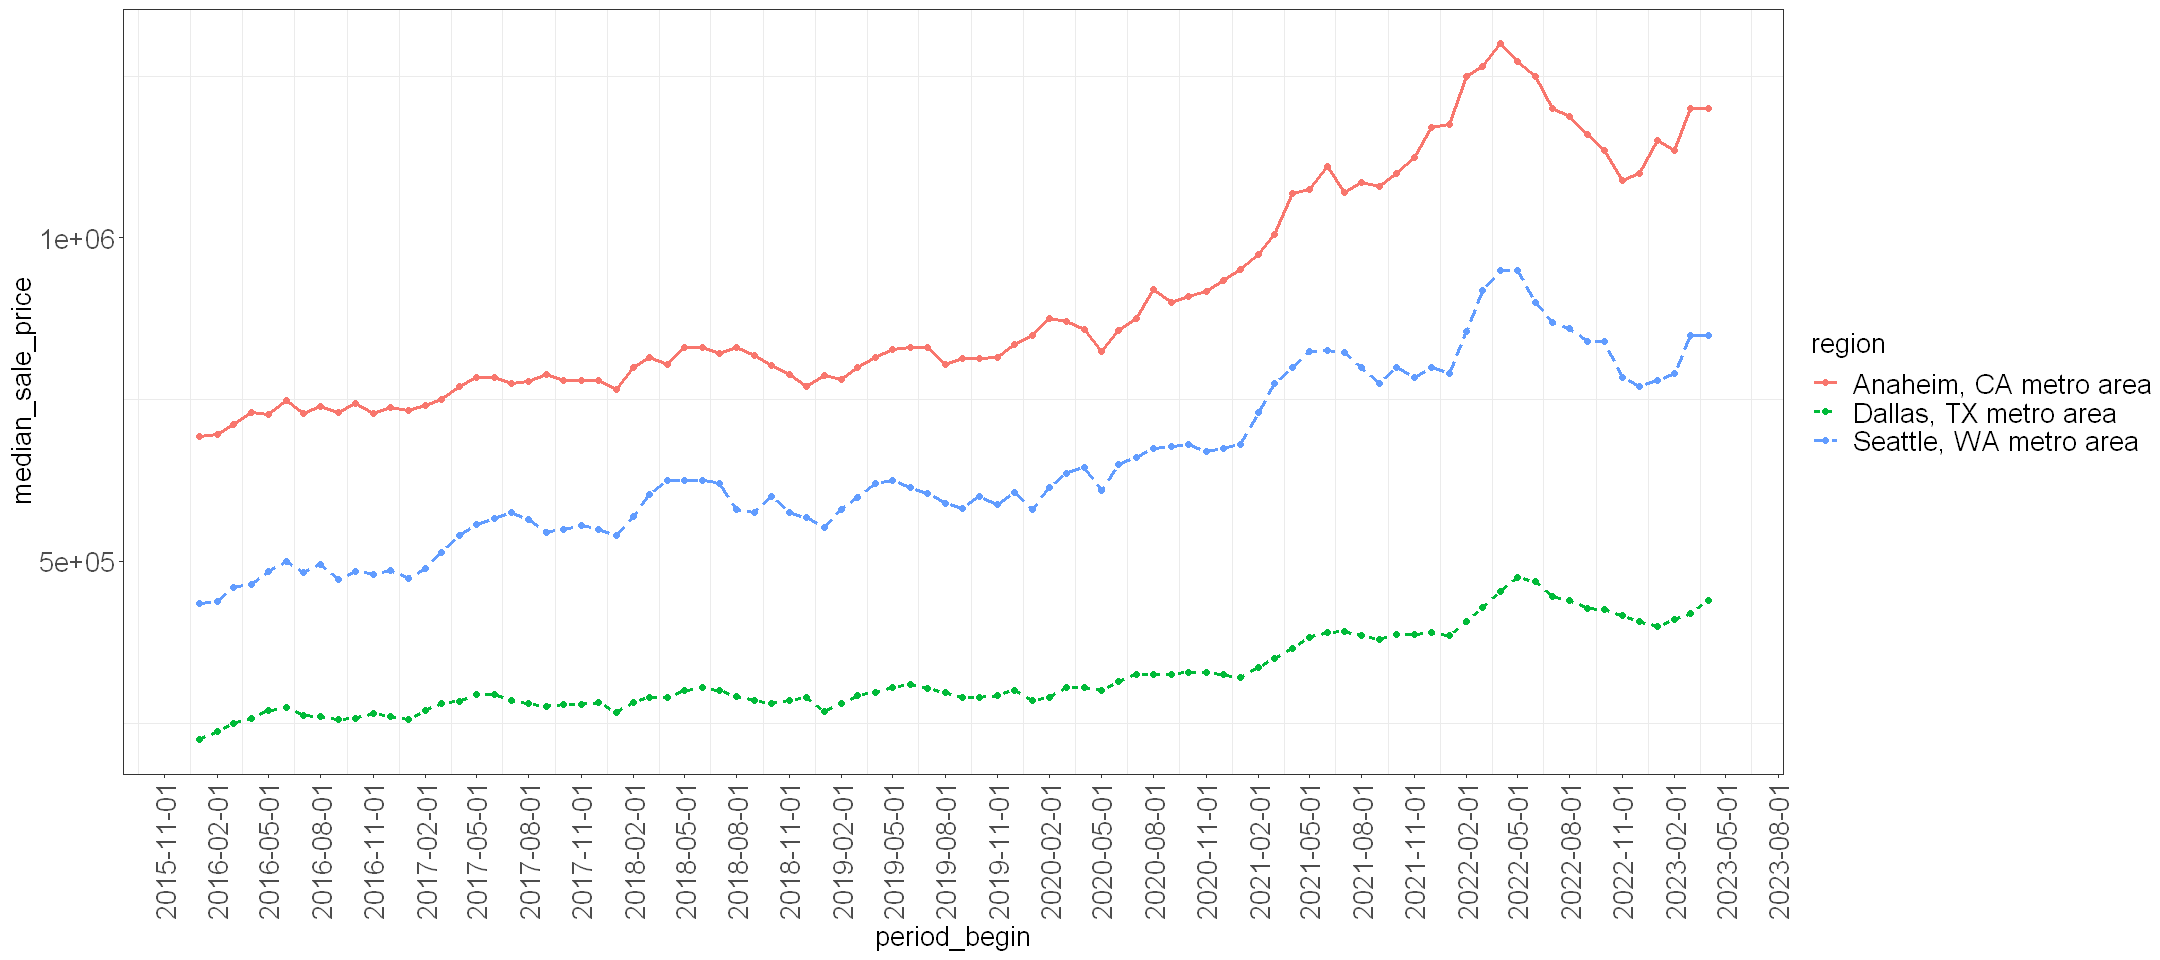

In [20]:
# Seattle
metro_t <- 'Seattle, WA metro area'
metro_sel <- c(metro_t, 'Dallas, TX metro area', 
               'Anaheim, CA metro area')  # td_shapedtw-rank2, 'Austin, TX metro area', 18; td_wdtw-rank2, , 'Modesto, CA metro area' 9 
ggplot(data=dt_sel[region %in% metro_sel], aes(x=period_begin, y=median_sale_price, color=region)) + 
  geom_line(aes(linetype=region), size=1) +
  geom_point() +
  scale_x_date(breaks = "3 month") + 
  theme_bw() +
  theme(
    axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1),
    axis.title = element_text(size = 16), axis.text = element_text(size = 16), 
    legend.title = element_text(size = 16), legend.text = element_text(size = 16),
    plot.background = element_blank(),
    panel.grid.major = element_blank()
  )

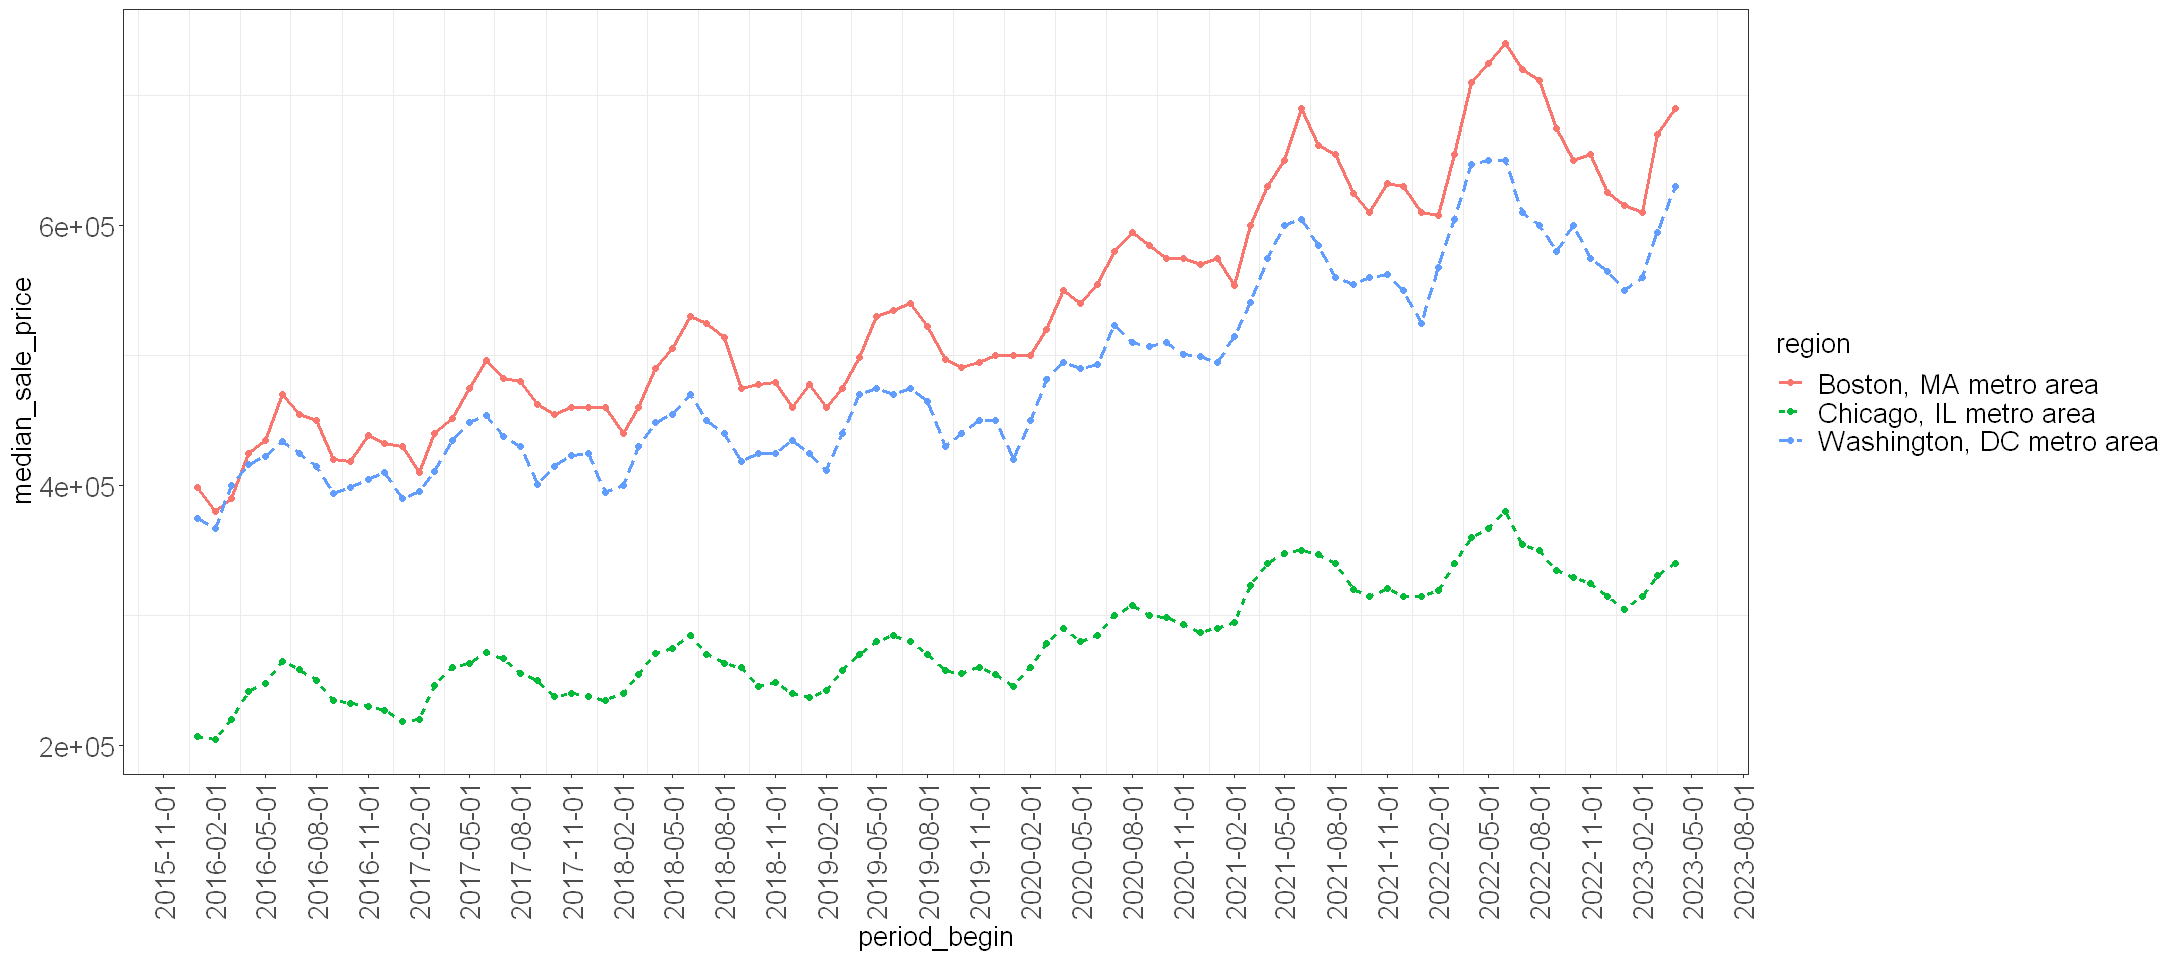

In [20]:
# Chicago
metro_t <- 'Chicago, IL metro area'
metro_sel <- c(metro_t, 'Boston, MA metro area', 'Washington, DC metro area')  # td_shapedtw-rank2, 4, # 'Seattle, WA metro area', 8
ggplot(data=dt_sel[region %in% metro_sel], aes(x=period_begin, y=median_sale_price, color=region)) + 
  geom_line(aes(linetype=region), size=1) +
  geom_point() +
  scale_x_date(breaks = "3 month") + 
  theme_bw() +
  theme(
    axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1),
    axis.title = element_text(size = 16), axis.text = element_text(size = 16), 
    legend.title = element_text(size = 16), legend.text = element_text(size = 16),
    plot.background = element_blank(),
    panel.grid.major = element_blank()
  )

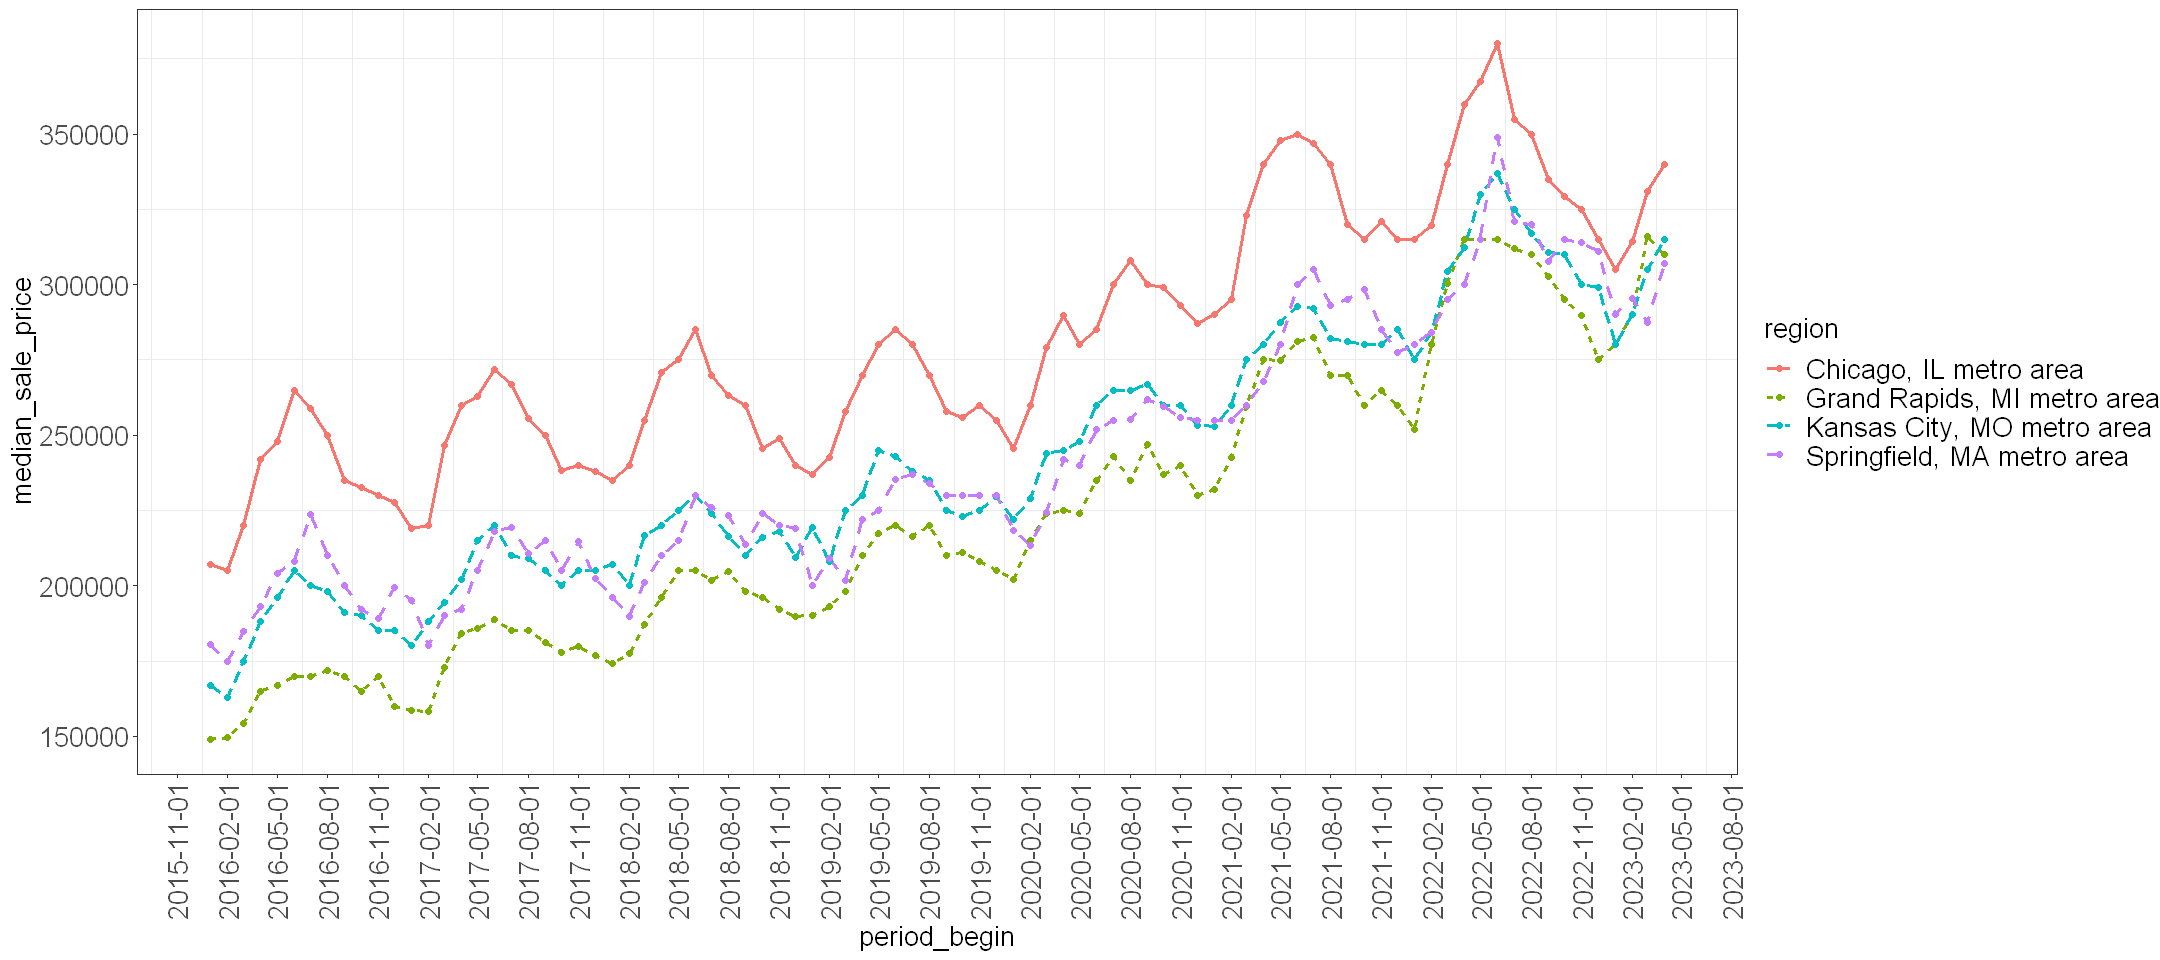

In [22]:
# Chicago
metro_t <- 'Chicago, IL metro area'
metro_sel <- c(metro_t, 'Kansas City, MO metro area', 'Grand Rapids, MI metro area', # 'Seattle, WA metro area', # td_shapedtw-rank8
               'Springfield, MA metro area' )  # td_shapedtw-rank6, 17, td_wdtw-rank # 'Lake County, IL metro area' 8, # 16
ggplot(data=dt_sel[region %in% metro_sel], aes(x=period_begin, y=median_sale_price, color=region)) + 
  geom_line(aes(linetype=region), size=1) +
  geom_point() +
  scale_x_date(breaks = "3 month") + 
  theme_bw() +
  theme(
    axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1),
    axis.title = element_text(size = 16), axis.text = element_text(size = 16), 
    legend.title = element_text(size = 16), legend.text = element_text(size = 16),
    plot.background = element_blank(),
    panel.grid.major = element_blank()
  )

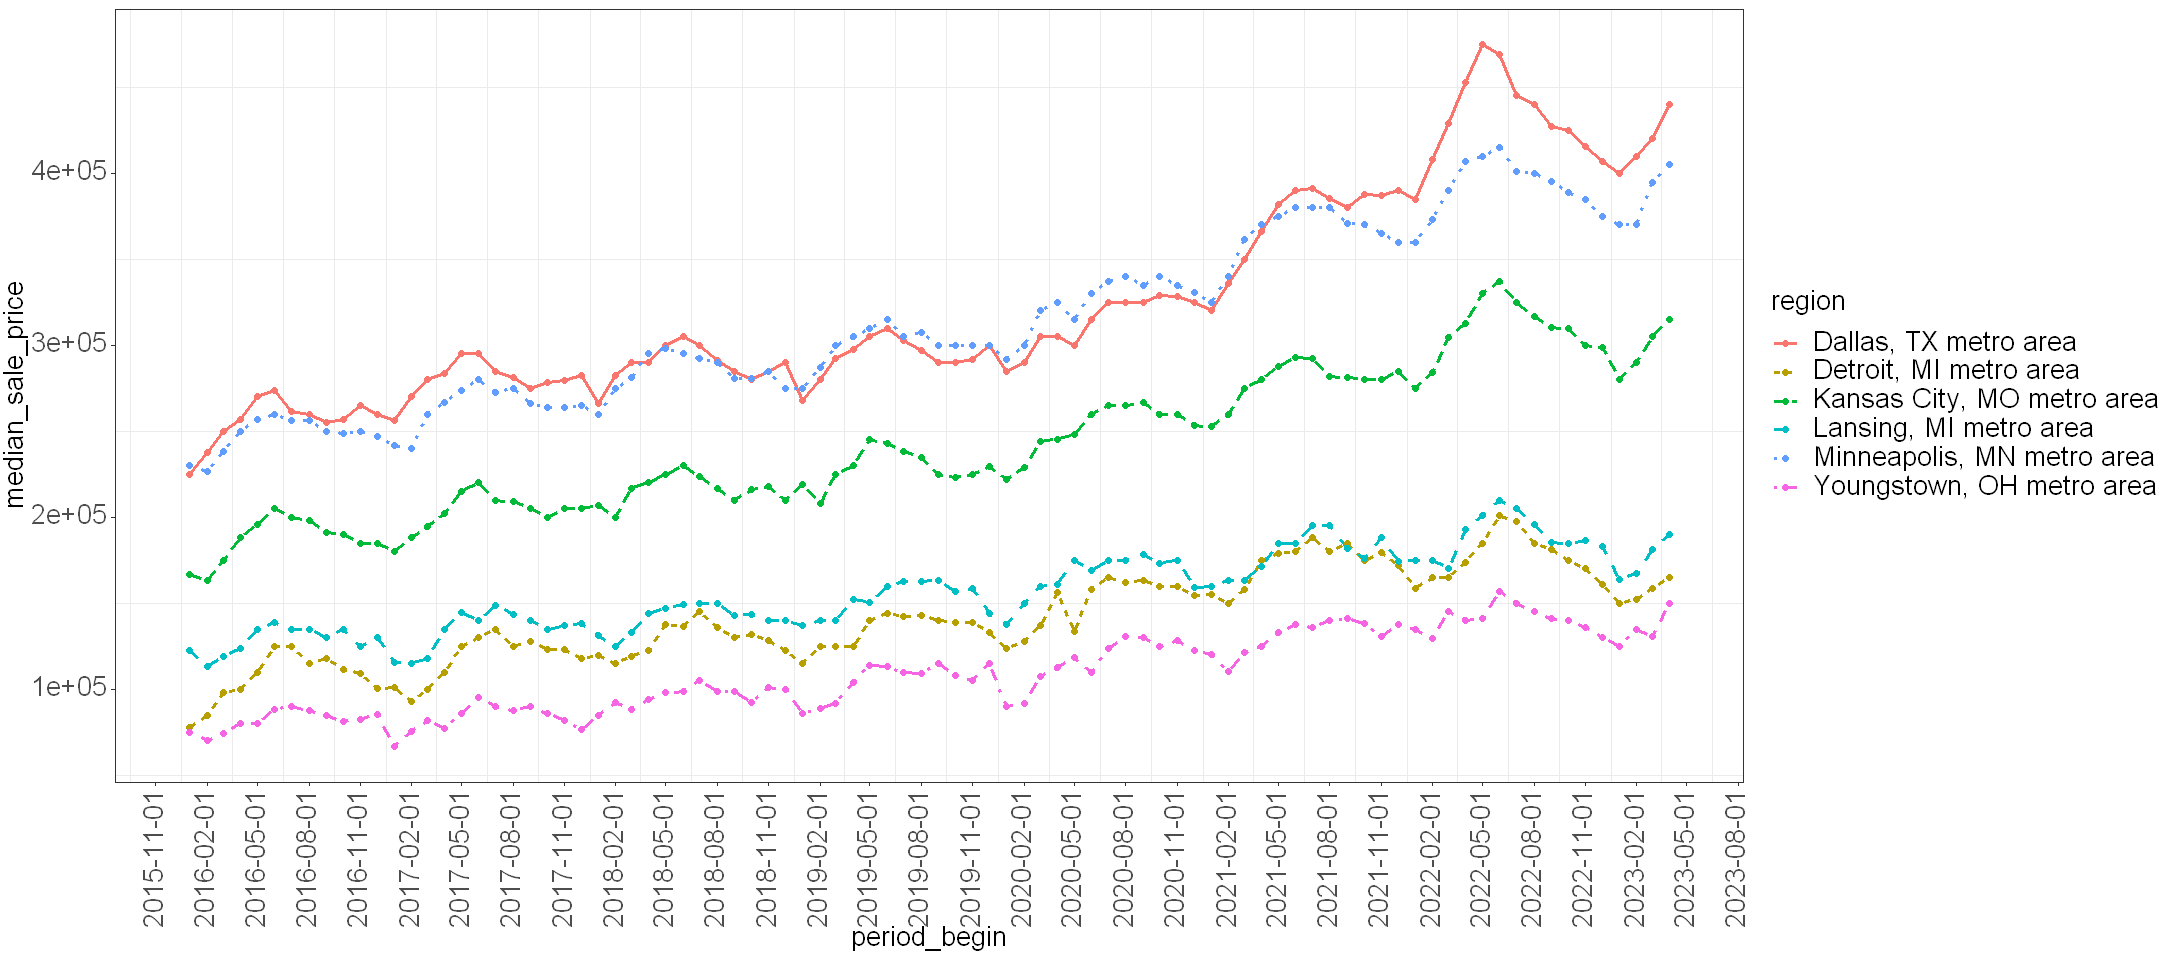

In [23]:
# Detroit
metro_t <- 'Detroit, MI metro area'
metro_sel <- c(metro_t, 'Kansas City, MO metro area', 'Minneapolis, MN metro area', 'Dallas, TX metro area', 
               'Youngstown, OH metro area', 'Lansing, MI metro area')  # td_shapedtw-rank4, 6, 16, td_wdtw-rank11, 19
ggplot(data=dt_sel[region %in% metro_sel], aes(x=period_begin, y=median_sale_price, color=region)) + 
  geom_line(aes(linetype=region), size=1) +
  geom_point() +
  scale_x_date(breaks = "3 month") + 
  theme_bw() +
  theme(
    axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1),
    axis.title = element_text(size = 16), axis.text = element_text(size = 16), 
    legend.title = element_text(size = 16), legend.text = element_text(size = 16),
    plot.background = element_blank(),
    panel.grid.major = element_blank()
  )

# Prediction Exercise

BSTS:

1. Use **DTW, WDTW, TD-WDTW, ShapeDTW, and TD-ShapeDTW** to find the top 10 or 20 matching results with data from 2016-01-01 to 2022-12-01 (6-year montly data), respectively

2. **Train 5 BSTS models** using the top 10 or 20 matching results from different methods

3. **redict the price trend** in the first four months in 2023 based on the trained BSTS models

ML model (XGBoost, LSTM, Gated RNN):

+ stock market data (prediction purpose: US ~ UK, Singapore, Hongkong, Japan, France/Germany)

+ semi-conduct industry

References:

+ https://otexts.com/fpp3/advanced.htmlhttps://otexts.com/fpp3/advanced.html